In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

### How To:
Simple run the notebook and insert the page content (STRG+A, STRG+C) into the input field.

In [2]:
def drawECDF():
    run:bool = True
    i = 0

    # Save dataframes, major and time period here
    df_list = []
    major_list = []
    time_period_list = []

    while run:
        i = i + 1
        # Get input (STRG+A and STRG+C to copy all content)
        raw = input("Please enter site content (STRG+A, STRG+C): ")

        # If empty input break loop
        if raw == "":
            run = False
            print(f"Reading ended after {i - 1} iterations\n")
            break

        # Transform raw String: Find first '1,0' and cut off anything before it
        cut_index = raw.find("1,0")
        raw_grades = raw[cut_index:]
        raw_info = raw[:cut_index].split(" ")

        # Get field of study
        major = raw_info[7] + " " + raw_info[8]
        # Get time period
        time_period = raw_info[10] + " " + raw_info[11] + " " + raw_info[12] + " " + raw_info[13] + " "+ raw_info[14]

        # Split data
        splitted_list = raw_grades.split(" ")
        grades = []
        percentage = []
        grades.append(splitted_list[0].replace(",", "."))

        # Crawl Grades and Percentage, i.e. even/uneven index and replace comma with point for calculations
        for x in range(1, len(splitted_list)):
            if x % 2 == 0:
                grades.append(splitted_list[x].replace(",", "."))
            elif x % 2 != 0:
                percentage.append(splitted_list[x].replace(",", "."))

        # Add to pandas Df
        df = pd.DataFrame({"Grades": grades, "Percentage": percentage}, dtype=float)
        df["Cum. Percentage"] = df["Percentage"].cumsum()
        # Drop Percentage
        df.drop("Percentage", axis=1, inplace=True)

        # Save finalized df in df_list out of the loop
        df_list.append(df)
        major_list.append(major)
        time_period_list.append(time_period)

    return df_list, major_list, time_period_list

# Call function and get data
df_list, major_list, time_period_list = drawECDF()
# Append major and time period for plotting
major_and_time_period_list = [major + ": " + time_period for major in major_list for time_period in time_period_list]

Reading ended after 5 iterations



## Plotting

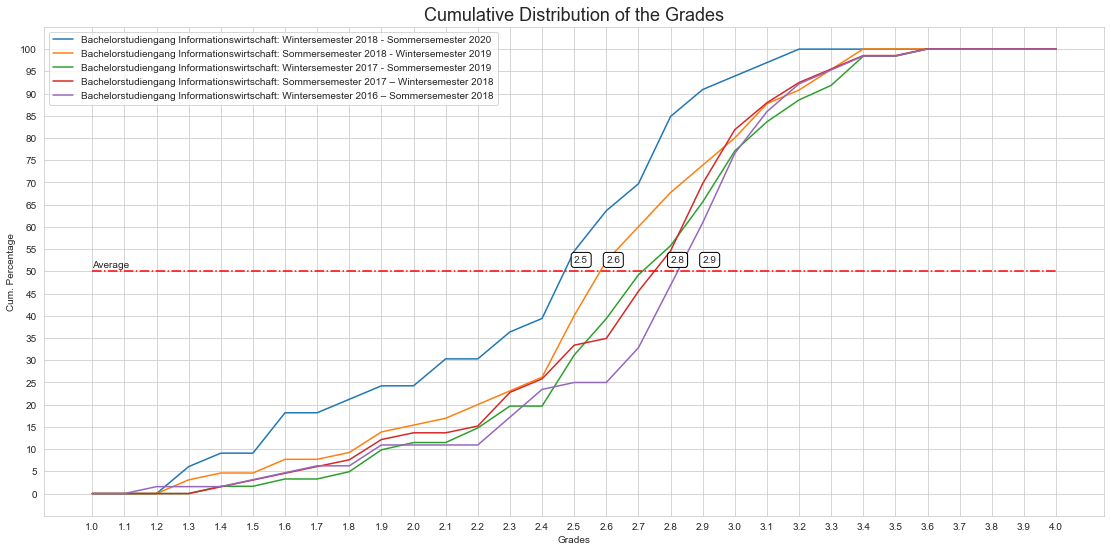

In [3]:
# Plot and Plot Settings
plt.figure(figsize=(19,9))
plt.title("Cumulative Distribution of the Grades", size=18)
for df in df_list:
    sns.lineplot(data=df, x="Grades", y="Cum. Percentage")
    # Get mean grade
    mean = df[df["Cum. Percentage"] >= 50].iloc[0, 0]
    # Annotate mean grade in plot
    plt.annotate(text=mean, xy=(mean, 50+2), bbox=dict(boxstyle="round", edgecolor="black", pad=0.3, fc="w"))
plt.annotate(text="Average", xy=(1.0, 51.0))
plt.xticks(np.arange(1, 4.1, 0.1))
plt.yticks(np.arange(0, 105, 5))
plt.legend(major_and_time_period_list)
# Draw average line
plt.hlines(y=50, color = "red", linestyles="-.", xmin=1, xmax=4, label="Average")
plt.savefig("assets/figure.png", dpi=256)
plt.show()